# Density based clustering the Facebook graph
Kishan Ved

22110122

### Import the dataframe

In [59]:
import pandas as pd
import numpy as np

df = pd.read_csv('musae_facebook_target.csv');
df

,id,facebook_id,page_name,page_type
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician
...,...,...,...,...
22465,22465,1379955382222841,Kurt Wiegel MdL,politician
22466,22466,1651527995097082,dubdub Stories,company
22467,22467,155369444540412,Ministerio del Interior - Paraguay,government
22468,22468,175067819212798,Tottus Perú,company


### Import the edges

In [60]:
edges_df = pd.read_csv("musae_facebook_edges.csv")
edges_df

,id_1,id_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829
...,...,...
170997,20188,20188
170998,22340,22383
170999,22348,22348
171000,5563,5563


### 2-Approx algorithm

1. Find the vertex of the minimum degree: v

2. tot - deg[v] = e(s,s)  {deg is a dict containing degrees}

3. Remove v from deg

4. Update deg of vertices that were connected to v

5. Find the density 

6. Store the vertex removed and the density of the subgraph obtained after this

### Dictionaries of degree, neighbors and self-loops (if >0) of vertices

In [61]:
deg = {}
neighbors = {}
self_loops = {}

for _, row in edges_df.iterrows():
    if row['id_1'] == row['id_2']:
        if row['id_1'] in self_loops:
            self_loops[row['id_1']] += 1
        else:
            self_loops[row['id_1']] = 1

    for node in ['id_1', 'id_2']:
        if row[node] in deg:
            deg[row[node]] += 1
        else:
            deg[row[node]] = 1

    # Append to the neighbors list
    if row['id_1'] in neighbors:
        neighbors[row['id_1']].append(row['id_2'])
    else:
        neighbors[row['id_1']] = [row['id_2']]

    if row['id_2'] in neighbors:
        neighbors[row['id_2']].append(row['id_1'])
    else:
        neighbors[row['id_2']] = [row['id_1']]


### Total edges in the graph

In [62]:
tot = sum(deg.values())/2
tot # e(S,S)

171002.0

### Total vertices in the graph

In [63]:
ctr = len(deg) # |S|
total_vertices = ctr
total_vertices

22470

### Arrays of density and vertex

In [64]:
density = [] # stores densities
vertex = [] # vertex[0:i] (i included) contains vertices removed to achive density[i+1], i+1 as density[0] is for the full graph

### Density of the full graph

In [65]:
density.append(tot/total_vertices) # Density of the full graph
print(density)

[7.610235870048954]


### Function to calucate the density of the subgraph after removing the min. degree vertex

In [66]:
def find_density_greedy():
    global tot
    global deg
    global ctr
    global edges_df
    global vertex
    
    v = min(deg, key=lambda k: deg[k]) # vertex with minimum degree
    vertex.append(v) # Store the removed vertex
    ctr = ctr - 1 # decrease |S| by 1 (as v is removed)
    tot = tot - deg[v] # Update e(S,S)
    # Check for self edges, in that case, we subtracted 2, but we must subtract only one
    if v in self_loops:
        tot += self_loops[v]
    
    den = tot / ctr
    density.append(den)
    deg.pop(v) # Remove v from deg
    
    selected_rows = pd.Series(neighbors[v])
    deg_update = selected_rows.value_counts().to_dict()
    for ver, count in deg_update.items():
        if ver in deg:
            deg[ver] -= count

In [67]:
i = 1
while(ctr>1):
    i+=1
    if (i%1000==0): # Prints i to get an estimate of how much execution is done
        print(i)
    find_density_greedy()
    if(tot != sum(deg.values())/2): # Checks for correctness
        print("here")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000


In [68]:
density = np.array(density)

In [69]:
x = np.argmax(density)
print("Densest subgraph has density:",density[x])

Densest subgraph has density: 35.006230529595015


### Visualizing the densities

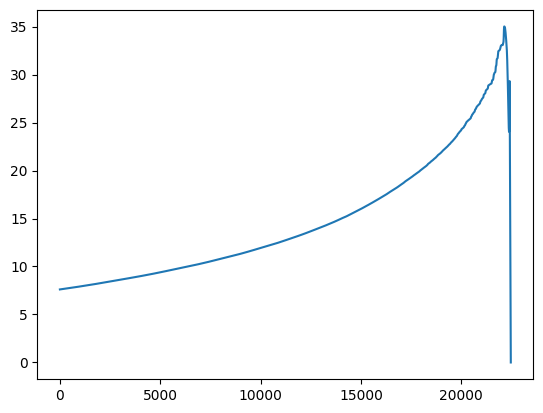

In [70]:
import matplotlib.pyplot as plt

plt.plot(np.arange(0,total_vertices),density)

In [71]:
print(x)

22149


In [72]:
graph = []
for i in list(neighbors.keys()): # As neighbors.keys() contains all the nodes currently in the graph
    if i not in vertex[:x]: # 0 to x-1 as density[0] was of full graph, so 1...x of denisty is 0...x-1 for vertices
        graph.append(i)
print("Number of nodes in the densest subgraph",len(graph))

Number of nodes in the densest subgraph 321


### Full Graph nodes:

In [73]:
fullgraph = {}
for ver in list(neighbors.keys()):
    type = df.loc[ver, 'page_type']
    if(type in fullgraph.keys()):
        fullgraph[type] += 1
    else:
        fullgraph[type] = 1

fullgraph

{'tvshow': 3327, 'government': 6880, 'company': 6495, 'politician': 5768}

### Densest Cluster nodes:

In [74]:
dense1 = {}
for ver in graph:
    type = df.loc[ver, 'page_type']
    if(type in dense1.keys()):
        dense1[type] += 1
    else:
        dense1[type] = 1

print("Node info:",dense1)

Node info: {'government': 257, 'company': 4, 'tvshow': 60}


In [75]:
df[df['id'].isin(graph)]

,id,facebook_id,page_name,page_type
44,44,1507698529534072,APB FOX,tvshow
127,127,354595427910013,GovX,company
159,159,167394579972573,JRTC and Fort Polk,government
568,568,127428534470290,The Orville,tvshow
679,679,146451038734267,Michigan National Guard,government
...,...,...,...,...
22252,22252,174788155866586,U.S. Army School of Music,government
22265,22265,61575637587,U.S. Pacific Command,government
22328,22328,114802901909136,North Carolina National Guard,government
22349,22349,110318209007293,21st Theater Sustainment Command,government


In [76]:
entropy=0
for x in dense1.values():
    entropy += -1*(x/sum(dense1.values()))*np.log(x/sum(dense1.values()))
print("Entropy of the densest subgraph:",entropy)

Entropy of the densest subgraph: 0.5461501418344485


### Peeling this densest subgraph from the graph

In [77]:
edges_df = edges_df[~edges_df.isin(graph).any(axis=1)]

In [78]:
deg = {}
deg2 = {} # A copy of deg
neighbors = {}
self_loops = {}

for _, row in edges_df.iterrows():
    if row['id_1'] == row['id_2']:
        if row['id_1'] in self_loops:
            self_loops[row['id_1']] += 1
        else:
            self_loops[row['id_1']] = 1

    for node in ['id_1', 'id_2']:
        if row[node] in deg:
            deg[row[node]] += 1
            deg2[row[node]] += 1
        else:
            deg[row[node]] = 1
            deg2[row[node]] = 1

    # Append to the neighbors list
    if row['id_1'] in neighbors:
        neighbors[row['id_1']].append(row['id_2'])
    else:
        neighbors[row['id_1']] = [row['id_2']]

    if row['id_2'] in neighbors:
        neighbors[row['id_2']].append(row['id_1'])
    else:
        neighbors[row['id_2']] = [row['id_1']]

## Iteration 2

### Finding the densest subgraph in the remaining graph

In [79]:
tot = sum(deg.values())/2
print("Number of edges e(S,S) is:",tot) # e(S,S)

ctr = len(deg) # |S|
total_vertices = ctr
print("The total number of vertices in the graph is:",total_vertices)

density = [] # stores densities
vertex = [] # vertex[0:i] (i included) contains vertices removed to achive density[i+1], i+1 as density[0] is for the full graph

density.append(tot/total_vertices) # Density of the full graph
print("Density of the full graph is",density[0])

Number of edges e(S,S) is: 144473.0
The total number of vertices in the graph is: 22094
Density of the full graph is 6.539015117226397


In [80]:
i = 1
while(ctr>1):
    i+=1
    if (i%1000==0): # Prints i to get an estimate of how much execution is done
        print(i)
    find_density_greedy()
    if(tot != sum(deg.values())/2): # Checks for correctness
        print("here")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000


In [81]:
density = np.array(density)
x = np.argmax(density) - 1 # -1 as density[0] is the density of the full graph.
print("Densest subgraph has density:",density[x])

graph = []
for i in list(neighbors.keys()):
    if i not in vertex[:x+1]:
        graph.append(i)
print("Number of nodes in the densest subgraph",len(graph))

dense1 = {}
for ver in graph:
    type = df.loc[ver, 'page_type']
    if(type in dense1.keys()):
        dense1[type] += 1
    else:
        dense1[type] = 1

print("Node info:",dense1)

Densest subgraph has density: 25.153846153846153
Number of nodes in the densest subgraph 90
Node info: {'politician': 7, 'government': 83}


### The densest subgraph is:

In [82]:
df[df['id'].isin(graph)]

,id,facebook_id,page_name,page_type
173,173,134470763282957,European Union in Israel,government
238,238,160579703997119,European Union in Thailand,government
522,522,479130188842492,União Europeia na Guiné-Bissau,government
710,710,478590035626002,European Union in Mauritius,government
1078,1078,583097918426250,European Union in New Zealand,government
...,...,...,...,...
21211,21211,170400489279,Representação da Comissão Europeia em Portugal,government
21325,21325,492150400807824,Frans Timmermans,politician
21764,21764,340835129292987,European Union in Vietnam,government
22109,22109,283061845058938,Европейската комисия в България / European Com...,government


In [83]:
entropy=0
for x in dense1.values():
    entropy += -1*(x/sum(dense1.values()))*np.log(x/sum(dense1.values()))
print("Entropy of the densest subgraph:",entropy)

Entropy of the densest subgraph: 0.2733080982135448


### Peeling this densest subgraph from the graph

In [84]:
edges_df = edges_df[~edges_df.isin(graph).any(axis=1)]

## Iteration 3

### Finding the densest subgraph in the remaining graph

In [86]:
deg = {}
neighbors = {}
self_loops = {}

for _, row in edges_df.iterrows():
    if row['id_1'] == row['id_2']:
        if row['id_1'] in self_loops:
            self_loops[row['id_1']] += 1
        else:
            self_loops[row['id_1']] = 1

    for node in ['id_1', 'id_2']:
        if row[node] in deg:
            deg[row[node]] += 1
        else:
            deg[row[node]] = 1

    # Append to the neighbors list
    if row['id_1'] in neighbors:
        neighbors[row['id_1']].append(row['id_2'])
    else:
        neighbors[row['id_1']] = [row['id_2']]

    if row['id_2'] in neighbors:
        neighbors[row['id_2']].append(row['id_1'])
    else:
        neighbors[row['id_2']] = [row['id_1']]

In [87]:
tot = sum(deg.values())/2
print("Number of edges e(S,S) is:",tot) # e(S,S)

ctr = len(deg) # |S|
total_vertices = ctr
print("The total number of vertices in the graph is:",total_vertices)

density = [] # stores densities
vertex = [] # vertex[0:i] (i included) contains vertices removed to achive density[i+1], i+1 as density[0] is for the full graph

density.append(tot/total_vertices) # Density of the full graph
print("Density of the full graph is",density[0])

Number of edges e(S,S) is: 138811.0
The total number of vertices in the graph is: 21996
Density of the full graph is 6.310738316057465


In [88]:
i = 1
while(ctr>1):
    i+=1
    if (i%1000==0): # Prints i to get an estimate of how much execution is done
        print(i)
    find_density_greedy()
    if(tot != sum(deg.values())/2): # Checks for correctness
        print("here")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000


In [89]:
density = np.array(density)
x = np.argmax(density) - 1 # -1 as density[0] is the density of the full graph.
print("Densest subgraph has density:",density[x])

graph = []
for i in list(neighbors.keys()):
    if i not in vertex[:x+1]:
        graph.append(i)
print("Number of nodes in the densest subgraph",len(graph))

dense1 = {}
for ver in graph:
    type = df.loc[ver, 'page_type']
    if(type in dense1.keys()):
        dense1[type] += 1
    else:
        dense1[type] = 1

print("Node info:",dense1)

Densest subgraph has density: 20.39265536723164
Number of nodes in the densest subgraph 707
Node info: {'government': 470, 'company': 3, 'politician': 196, 'tvshow': 38}


### The densest subgraph is:

In [90]:
df[df['id'].isin(graph)]

,id,facebook_id,page_name,page_type
88,88,70710067457,"United States Embassy - Riga, Latvia",government
106,106,145794842231097,Chad Griffith - Lake Macquarie,politician
187,187,464998863536680,Bill Shorten MP,politician
197,197,1431984283714112,U.S. Forest Service,government
296,296,205572482794329,US National Weather Service Topeka Kansas,government
...,...,...,...,...
22404,22404,419314404818772,Christina Jantz-Herrmann,politician
22405,22405,60367306581,American Center New Delhi,government
22414,22414,720595767983984,Frank Junge,politician
22435,22435,120961761279906,Deborah O'Neill,politician


In [91]:
entropy=0
for x in dense1.values():
    entropy += -1*(x/sum(dense1.values()))*np.log(x/sum(dense1.values()))
print("Entropy of the densest subgraph:",entropy)

Entropy of the densest subgraph: 0.8073970723241295


### Peeling this densest subgraph from the graph

In [92]:
edges_df = edges_df[~edges_df.isin(graph).any(axis=1)]

## Iteration 4

### Finding the densest subgraph in the remaining graph

In [93]:
deg = {}
neighbors = {}
self_loops = {}

for _, row in edges_df.iterrows():
    if row['id_1'] == row['id_2']:
        if row['id_1'] in self_loops:
            self_loops[row['id_1']] += 1
        else:
            self_loops[row['id_1']] = 1

    for node in ['id_1', 'id_2']:
        if row[node] in deg:
            deg[row[node]] += 1
        else:
            deg[row[node]] = 1

    # Append to the neighbors list
    if row['id_1'] in neighbors:
        neighbors[row['id_1']].append(row['id_2'])
    else:
        neighbors[row['id_1']] = [row['id_2']]

    if row['id_2'] in neighbors:
        neighbors[row['id_2']].append(row['id_1'])
    else:
        neighbors[row['id_2']] = [row['id_1']]

In [94]:
tot = sum(deg.values())/2
print("Number of edges e(S,S) is:",tot) # e(S,S)

ctr = len(deg) # |S|
total_vertices = ctr
print("The total number of vertices in the graph is:",total_vertices)

density = [] # stores densities
vertex = [] # vertex[0:i] (i included) contains vertices removed to achive density[i+1], i+1 as density[0] is for the full graph

density.append(tot/total_vertices) # Density of the full graph
print("Density of the full graph is",density[0])

Number of edges e(S,S) is: 108687.0
The total number of vertices in the graph is: 21186
Density of the full graph is 5.13013310676862


In [95]:
i = 1
while(ctr>1):
    i+=1
    if (i%1000==0): # Prints i to get an estimate of how much execution is done
        print(i)
    find_density_greedy()
    if(tot != sum(deg.values())/2): # Checks for correctness
        print("here")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000


In [96]:
density = np.array(density)
x = np.argmax(density) - 1 # -1 as density[0] is the density of the full graph.
print("Densest subgraph has density:",density[x])

graph = []
for i in list(neighbors.keys()):
    if i not in vertex[:x+1]:
        graph.append(i)
print("Number of nodes in the densest subgraph",len(graph))

dense1 = {}
for ver in graph:
    type = df.loc[ver, 'page_type']
    if(type in dense1.keys()):
        dense1[type] += 1
    else:
        dense1[type] = 1

print("Node info:",dense1)

Densest subgraph has density: 16.673076923076923
Number of nodes in the densest subgraph 51
Node info: {'government': 51}


### The densest subgraph is:

In [97]:
df[df['id'].isin(graph)]

,id,facebook_id,page_name,page_type
196,196,418893364920895,Préfet de Loir et Cher,government
478,478,1497254630524271,Préfet de la Saône-et-Loire,government
992,992,219953911434100,Préfet de l'Aisne,government
1503,1503,121386187886932,Préfecture de Police,government
1960,1960,105063419566358,Ministère des Sports,government
2405,2405,146054485530564,Ministère de la Cohésion des Territoires,government
2605,2605,149819368364622,Préfet de Meurthe-et-Moselle,government
2644,2644,505487189520312,Préfecture de la Guyane,government
3451,3451,202866606417783,Ministère de la Culture,government
3678,3678,133776633309674,Ministère des Outre-Mer,government


In [98]:
entropy=0
for x in dense1.values():
    entropy += -1*(x/sum(dense1.values()))*np.log(x/sum(dense1.values()))
print("Entropy of the densest subgraph:",entropy)

Entropy of the densest subgraph: 0.0


### Peeling this densest subgraph from the graph

In [99]:
edges_df = edges_df[~edges_df.isin(graph).any(axis=1)]

## Iteration 5

### Finding the densest subgraph in the remaining graph

In [100]:
deg = {}
neighbors = {}
self_loops = {}

for _, row in edges_df.iterrows():
    if row['id_1'] == row['id_2']:
        if row['id_1'] in self_loops:
            self_loops[row['id_1']] += 1
        else:
            self_loops[row['id_1']] = 1

    for node in ['id_1', 'id_2']:
        if row[node] in deg:
            deg[row[node]] += 1
        else:
            deg[row[node]] = 1

    # Append to the neighbors list
    if row['id_1'] in neighbors:
        neighbors[row['id_1']].append(row['id_2'])
    else:
        neighbors[row['id_1']] = [row['id_2']]

    if row['id_2'] in neighbors:
        neighbors[row['id_2']].append(row['id_1'])
    else:
        neighbors[row['id_2']] = [row['id_1']]

In [101]:
tot = sum(deg.values())/2
print("Number of edges e(S,S) is:",tot) # e(S,S)

ctr = len(deg) # |S|
total_vertices = ctr
print("The total number of vertices in the graph is:",total_vertices)

density = [] # stores densities
vertex = [] # vertex[0:i] (i included) contains vertices removed to achive density[i+1], i+1 as density[0] is for the full graph

density.append(tot/total_vertices) # Density of the full graph
print("Density of the full graph is",density[0])

Number of edges e(S,S) is: 106801.0
The total number of vertices in the graph is: 21129
Density of the full graph is 5.054711533910739


In [102]:
i = 1
while(ctr>1):
    i+=1
    if (i%1000==0): # Prints i to get an estimate of how much execution is done
        print(i)
    find_density_greedy()
    if(tot != sum(deg.values())/2): # Checks for correctness
        print("here")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000


In [103]:
density = np.array(density)
x = np.argmax(density) - 1 # -1 as density[0] is the density of the full graph.
print("Densest subgraph has density:",density[x])

graph = []
for i in list(neighbors.keys()):
    if i not in vertex[:x+1]:
        graph.append(i)
print("Number of nodes in the densest subgraph",len(graph))

dense1 = {}
for ver in graph:
    type = df.loc[ver, 'page_type']
    if(type in dense1.keys()):
        dense1[type] += 1
    else:
        dense1[type] = 1

print("Node info:",dense1)

Densest subgraph has density: 15.9402390438247
Number of nodes in the densest subgraph 250
Node info: {'politician': 173, 'government': 77}


### The densest subgraph is:

In [104]:
df[df['id'].isin(graph)]

,id,facebook_id,page_name,page_type
113,113,404948826259784,Senator James McGrath,politician
290,290,568839896564552,Marie-Claude Bibeau,politician
321,321,325227794269092,"Rachael Harder, MP",politician
702,702,6229329915,Rodger Cuzner,politician
721,721,744295609010223,Murray Thompson MP,politician
...,...,...,...,...
22023,22023,267377223346665,Ministério de Minas e Energia,government
22025,22025,346272215464826,Erin O'Toole,politician
22084,22084,116868855036962,Craig Ondarchie MP,politician
22403,22403,6172639058,Dr. Hedy Fry,politician


In [105]:
entropy=0
for x in dense1.values():
    entropy += -1*(x/sum(dense1.values()))*np.log(x/sum(dense1.values()))
print("Entropy of the densest subgraph:",entropy)

Entropy of the densest subgraph: 0.6174910645388487
